In [1]:
#Training script
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parents[0]))

import os
from pathlib import Path
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from src.simclr import SimCLRModel, build_dataloader



/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/lightning_fabric/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


In [2]:
import torch
torch.set_float32_matmul_precision('medium')


In [3]:
DATA_ROOT = str(Path.home() / "projects/office-ssl/data/unlabeled/office_dataset")
BATCH_SIZE = 64   # reduce if OOM
IMG_SIZE = 224
NUM_WORKERS = 6
MAX_EPOCHS = 100


In [4]:
from pathlib import Path

data_root = Path(DATA_ROOT)
print("DATA_ROOT =", data_root.resolve())
print("Exists:", data_root.exists())

# list first few files
paths = list(data_root.glob("*"))
print("Number of entries in folder:", len(paths))
for p in paths[:10]:
    print("  ", p)


DATA_ROOT = /home/syed-mohammed-bilal/projects/office-ssl/data/unlabeled/office_dataset
Exists: True
Number of entries in folder: 6
   /home/syed-mohammed-bilal/projects/office-ssl/data/unlabeled/office_dataset/Angela
   /home/syed-mohammed-bilal/projects/office-ssl/data/unlabeled/office_dataset/Jim
   /home/syed-mohammed-bilal/projects/office-ssl/data/unlabeled/office_dataset/Pam
   /home/syed-mohammed-bilal/projects/office-ssl/data/unlabeled/office_dataset/Michael
   /home/syed-mohammed-bilal/projects/office-ssl/data/unlabeled/office_dataset/Dwight
   /home/syed-mohammed-bilal/projects/office-ssl/data/unlabeled/office_dataset/Kevin


In [5]:
import src.simclr as simclr
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset

class TwoViewDatasetFixed(Dataset):
    def __init__(self, root, transform):
        self.root = Path(root)
        # recursively find image files
        exts = [".jpg", ".jpeg", ".png"]
        self.paths = list(self.root.rglob('*.*'))  # recursive glob
        self.paths = [p for p in self.paths if p.suffix.lower() in ('.jpg', '.jpeg', '.png', '.webp')]
        if len(self.paths) == 0:
            raise RuntimeError(f"No image files found under {root}")
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        return self.transform(img), self.transform(img)

# patch the module
simclr.TwoViewDataset = TwoViewDatasetFixed

In [6]:
# instantiate dataloader
train_dl = simclr.build_dataloader(DATA_ROOT, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, img_size=IMG_SIZE)
print("Dataloader created with", len(train_dl.dataset), "images in", len(train_dl), "batches.")

Dataloader created with 1523 images in 24 batches.


In [7]:
#instantiate the model
model = SimCLRModel(base_model='resnet50', proj_hidden_dim=1024, proj_out_dim=128, temperature=0.5, lr=1e-4)
print("Model instantiated:", type(model).__name__)


/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model instantiated: SimCLRModel


In [18]:
#trainer and callbacks
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

# --- Logger ---
logger = TensorBoardLogger("logs", name="simclr")

# --- Callbacks ---
checkpoint_cb = ModelCheckpoint(
    dirpath="projects/office-ssl/checkpoints",
    filename="simclr-{epoch:02d}-{train_loss:.4f}",
    save_top_k=3,
    monitor="train_loss",
    mode="min"
)
lr_monitor = LearningRateMonitor(logging_interval="step")

# --- Trainer (modern API) ---
if torch.cuda.is_available():
    trainer = Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=MAX_EPOCHS,
        precision="16",          # optional for faster GPU training
        logger=logger,
        callbacks=[checkpoint_cb, lr_monitor],
        log_every_n_steps=10
    )
else:
    trainer = Trainer(
        accelerator="cpu",
        max_epochs=MAX_EPOCHS,
        logger=logger,
        callbacks=[checkpoint_cb, lr_monitor],
        log_every_n_steps=10
    )


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
#run training
trainer.fit(model, train_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | backbone  | ResNet     | 23.5 M
1 | projector | Sequential | 2.2 M 
-----------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
51.475    Total estimated model params size (MB)


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.02it/s, loss=3.83, v_num=3, train_loss_step=3.600, train_loss_epoch=3.840]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.94it/s, loss=3.83, v_num=3, train_loss_step=3.600, train_loss_epoch=3.840]


In [35]:
#confirmation
from pathlib import Path
import torch
from src.simclr import SimCLRModel

# Absolute checkpoint directory
ckpt_dir = Path.home() / "projects/office-ssl/checkpoints"

# Sorted by name (epoch number ascending)
ckpts = sorted(ckpt_dir.glob("*.ckpt"))
ckpt_path = ckpts[-1]  # latest
print(f"Loading checkpoint: {ckpt_path.name}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimCLRModel.load_from_checkpoint(str(ckpt_path))
model = model.eval().to(device)


Loading checkpoint: simclr-epoch=99-train_loss=3.8704.ckpt


In [36]:
#confirmation again
print("Device:", next(model.parameters()).device)
print("Backbone:", model.backbone.__class__.__name__)
print("Projector head:", model.projector)


Device: cuda:0
Backbone: ResNet
Projector head: Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=128, bias=True)
)


In [4]:
#prepare simple dataset for embedding extraction
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pathlib import Path

DATA_ROOT = Path.home() / "projects/office-ssl/data/unlabeled/office_dataset"

class SimpleDataset(Dataset):
    def __init__(self, root, transform):
        self.paths = list(Path(root).rglob('*.*'))
        self.paths = [p for p in self.paths if p.suffix.lower() in ('.jpg', '.jpeg', '.png', '.webp')]
        self.transform = transform

    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert('RGB')
        return self.transform(img), str(p)

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

dataset = SimpleDataset(DATA_ROOT, transform)
dataloader = DataLoader(dataset, batch_size=64, num_workers=4)


In [9]:
# Reload SimCLR checkpoint
from pathlib import Path
import torch
from src.simclr import SimCLRModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device =", device)

# where checkpoints are saved
ckpt_dir = Path.home() / "projects" / "office-ssl" / "checkpoints"
ckpts = sorted(ckpt_dir.glob("simclr-epoch*.ckpt"))
if len(ckpts) == 0:
    raise RuntimeError("No SimCLR checkpoints found! Did you run Step 1 training?")
    
best_simclr_ckpt = ckpts[-1]
print("Loading SimCLR checkpoint:", best_simclr_ckpt)

# load model
model = SimCLRModel.load_from_checkpoint(str(best_simclr_ckpt), strict=False)
model = model.to(device).eval()

print("Model loaded successfully.")


/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/lightning_fabric/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


device = cuda
Loading SimCLR checkpoint: /home/syed-mohammed-bilal/projects/office-ssl/checkpoints/simclr-epoch=99-train_loss=3.8704.ckpt


/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully.


In [10]:
#extract embeddings
import torch
import torch.nn as nn
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
embeddings = []
filenames = []

with torch.no_grad():
    for x, fnames in dataloader:
        x = x.to(device)
        feats = model.backbone(x)          # (B, feat_dim)
        feats = nn.functional.normalize(feats, dim=1).cpu().numpy()
        embeddings.append(feats)
        filenames.extend(fnames)

emb = np.concatenate(embeddings, axis=0)
print(" Embeddings shape:", emb.shape)


 Embeddings shape: (1523, 2048)


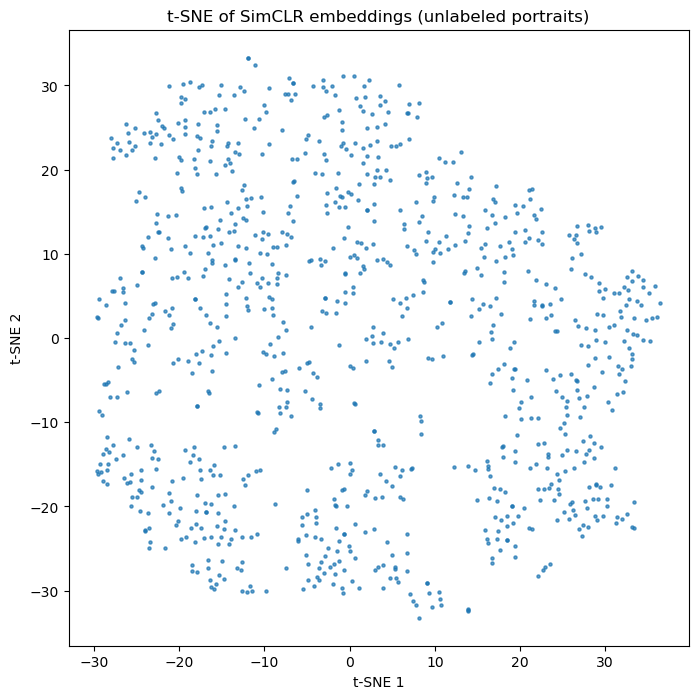

In [11]:
#Visualizing Using t-SNE (2-D Scatter Plot)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Subsample if very large
subset = 1000 if emb.shape[0] > 1000 else emb.shape[0]
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
vis = tsne.fit_transform(emb[:subset])

plt.figure(figsize=(8,8))
plt.scatter(vis[:,0], vis[:,1], s=5, alpha=0.7)
plt.title("t-SNE of SimCLR embeddings (unlabeled portraits)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.show()


In [20]:
#creating figures
from pathlib import Path

FIG_DIR = Path.home() / "projects" / "office-ssl" / "figures"
FIG_DIR.mkdir(exist_ok=True, parents=True)

plt.savefig(FIG_DIR / "simclr_tsne.png", dpi=300, bbox_inches="tight")
print("Saved:", FIG_DIR / "simclr_tsne.png")


Saved: /home/syed-mohammed-bilal/projects/office-ssl/figures/simclr_tsne.png


<Figure size 640x480 with 0 Axes>

In [15]:
#Clustering with K-Means
from sklearn.cluster import KMeans
import numpy as np

k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(emb)

unique, counts = np.unique(cluster_labels, return_counts=True)
print("Cluster counts:", dict(zip(unique, counts)))


Cluster counts: {0: 329, 1: 231, 2: 210, 3: 251, 4: 292, 5: 210}



Cluster 0 — 329 images


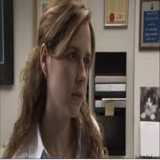

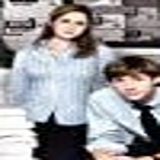

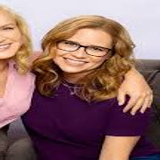

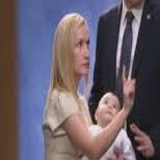

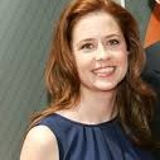

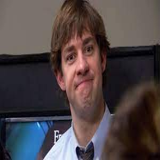


Cluster 1 — 231 images


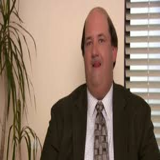

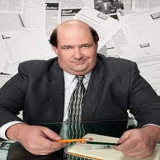

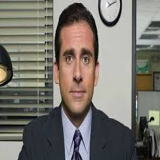

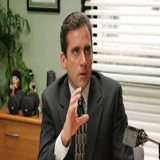

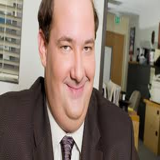

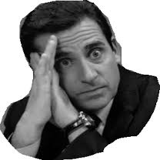


Cluster 2 — 210 images


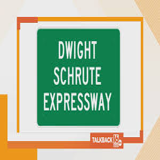

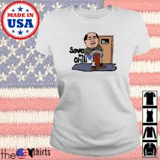

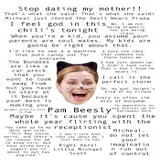

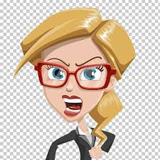

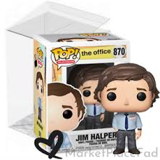

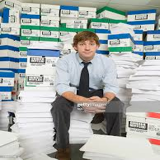


Cluster 3 — 251 images


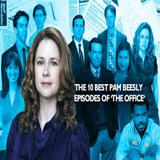

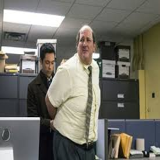

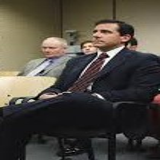

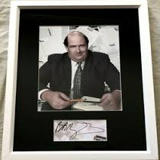

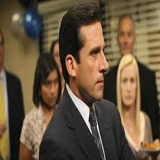

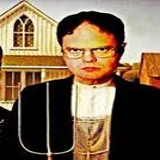


Cluster 4 — 292 images


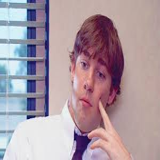

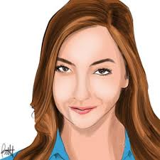

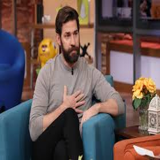

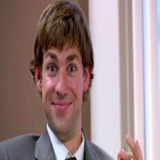

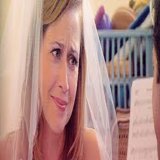

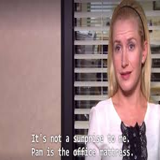


Cluster 5 — 210 images


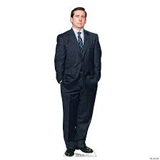

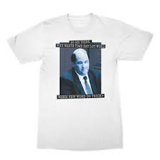

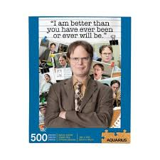

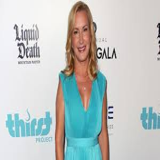

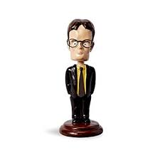

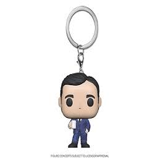

In [16]:
#Qualitative Cluster Check
import random
from PIL import Image
from IPython.display import display

for c in range(k):
    idxs = np.where(cluster_labels == c)[0]
    print(f"\nCluster {c} — {len(idxs)} images")
    sample_idxs = random.sample(list(idxs), min(6, len(idxs)))
    for i in sample_idxs:
        display(Image.open(filenames[i]).resize((160,160)))


In [19]:
#saves cluster visualization grids to disk
import matplotlib.pyplot as plt

def save_cluster_grid(cluster_id, img_paths, out_path, cols=6):
    images = [Image.open(p).resize((160,160)) for p in img_paths]
    
    rows = int(np.ceil(len(images) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))

    for ax, img in zip(axes.flatten(), images):
        ax.imshow(img)
        ax.axis("off")

    # hide empty cells
    for ax in axes.flatten()[len(images):]:
        ax.axis("off")

    plt.suptitle(f"Cluster {cluster_id} — {len(images)} images", fontsize=14)
    plt.tight_layout()
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
